<a href="https://colab.research.google.com/github/saritmaitra/Buy_Sell_Signals/blob/master/buy_%26_sell_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pandas import DataFrame 
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import pandas_datareader as web
!pip install plotly
import plotly.graph_objects as go

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [ ]:
print("....Data Loading...."); print();
print('\033[4mCrude Oil Spot Price\033[0m');
data = web.DataReader('CL=F', data_source = 'yahoo', start = '2000-01-01')
data

....Data Loading....

Crude Oil Spot Price


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-23,32.799999,31.950001,31.950001,32.049999,79385.0,32.049999
2000-08-24,32.240002,31.400000,31.900000,31.629999,72978.0,31.629999
2000-08-25,32.099998,31.320000,31.700001,32.049999,44601.0,32.049999
2000-08-28,32.919998,31.860001,32.040001,32.869999,46770.0,32.869999
2000-08-29,33.029999,32.560001,32.820000,32.720001,49131.0,32.720001
...,...,...,...,...,...,...
2020-09-11,37.820000,36.669998,37.009998,37.330002,363787.0,37.330002
2020-09-14,37.680000,36.820000,37.320000,37.259998,347563.0,37.259998
2020-09-15,38.570000,37.060001,37.279999,38.279999,348861.0,38.279999


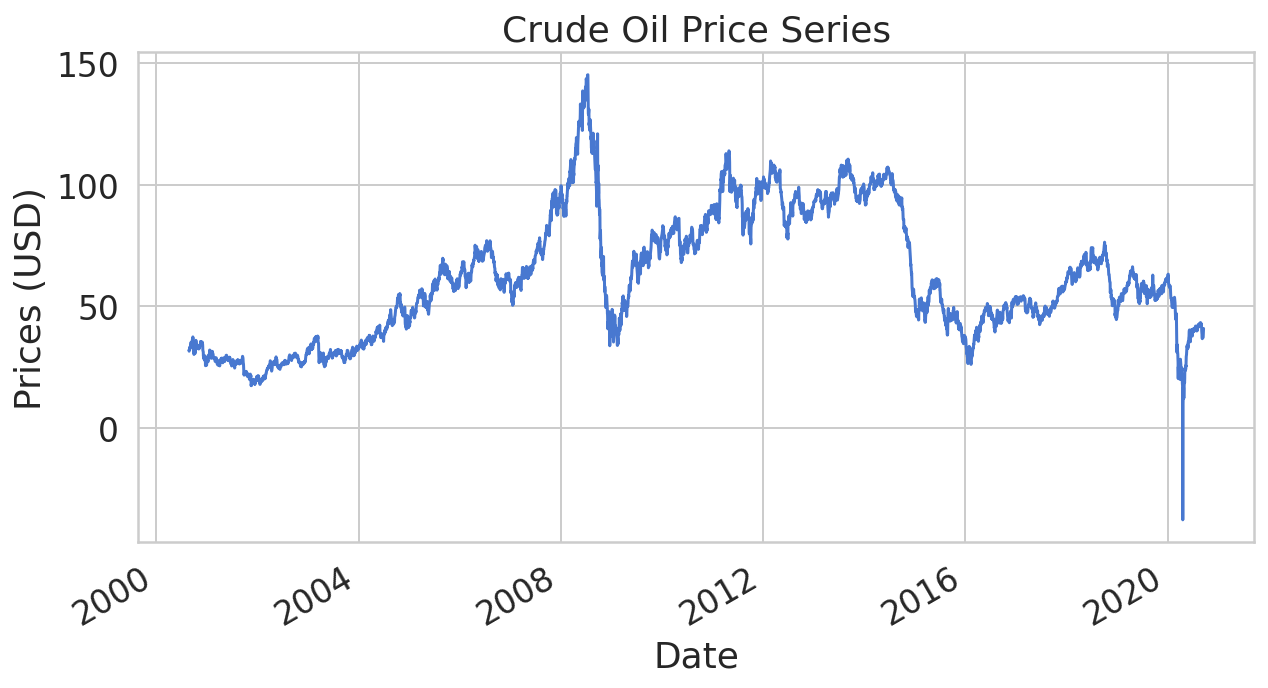

In [ ]:
df = data[['Close']]

# Plot the closing price 
df.Close.plot(figsize=(10, 5))
plt.ylabel("Prices (USD)")
plt.title("Crude Oil Price Series")
plt.show()

In [ ]:
df.loc[:,'ema10'] = (df.loc[:,'Close'].ewm(span=10,adjust=True,ignore_na=True).mean())
df.loc[:,'ema20'] = (df.loc[:,'Close'].ewm(span=20,adjust=True,ignore_na=True).mean())


df.loc[:, 'price_tomorrow'] = df.loc[:,'Close'].shift(-1)

df.dropna(inplace=True)
X = np.array(df[['ema10', 'ema20']])

# Define dependent variable
y = np.array(df['price_tomorrow'])

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=data.index[-100:],
                                     open=data['Open'][-100:],
                                     high=data['High'][-100:],
                                     low=data['Low'][-100:],
                                     close=data['Close'][-100:])])
fig.add_trace(go.Scatter(x = df.index[-100:], y = df.ema10[-100:], marker = dict(
        color = "blue"), name = "EMA10"))
fig.add_trace(go.Scatter(x = df.index[-100:], y = df.ema20[-100:], marker = dict(
        color = "gray"), name = "EMA10"))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(autosize = False, width = 1200, height = 600,)
fig.update_layout(title='Candlestick plot::Crude oil prices', yaxis_title='(US$)')
fig.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size = 0.80, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

Length train set: 4195
Length test set: 838


In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet

# Create a linear regression model
model = ElasticNet(max_iter=5000, random_state=0).fit(X_train, y_train)
print("Linear Regression model:")
print("Crude oil Price (y) = %.2f * 10 Days Moving Average (x1) \
+ %.2f * 20 Days Moving Average (x2) \
+ %.2f (constant)" % (model.coef_[0], model.coef_[1], model.intercept_))

Linear Regression model:
Crude oil Price (y) = 1.08 * 10 Days Moving Average (x1) + -0.08 * 20 Days Moving Average (x2) + 0.22 (constant)


In [ ]:
y_pred = DataFrame(model.predict(X_test), index = df[-len(y_test):].index, columns = ['price'])
y_test = DataFrame(y_test, index = df[-len(y_test):].index, columns = ['price'])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_pred.index, y = y_pred.price,
                         marker = dict(color ="red"), name = "Actual price"))
fig.add_trace(go.Scatter(x = y_test.index, y = y_test.price, marker=dict(
        color = "green"), name = "Predicted price"))

fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_layout(
    title= "Crude oil price (predicted vs actual", 
    yaxis_title = 'price (US$)',
    hovermode = "x",
    hoverdistance = 100, # Distance to show hover label of data point
    spikedistance = 1000) 
fig.update_layout(autosize = False, width = 1000, height = 400,)
fig.show()

In [ ]:
accuracy = model.score(X_test, y_test)
print("Accuracy: ", round(accuracy*100,2).astype(str) + '%')

Accuracy:  94.52%


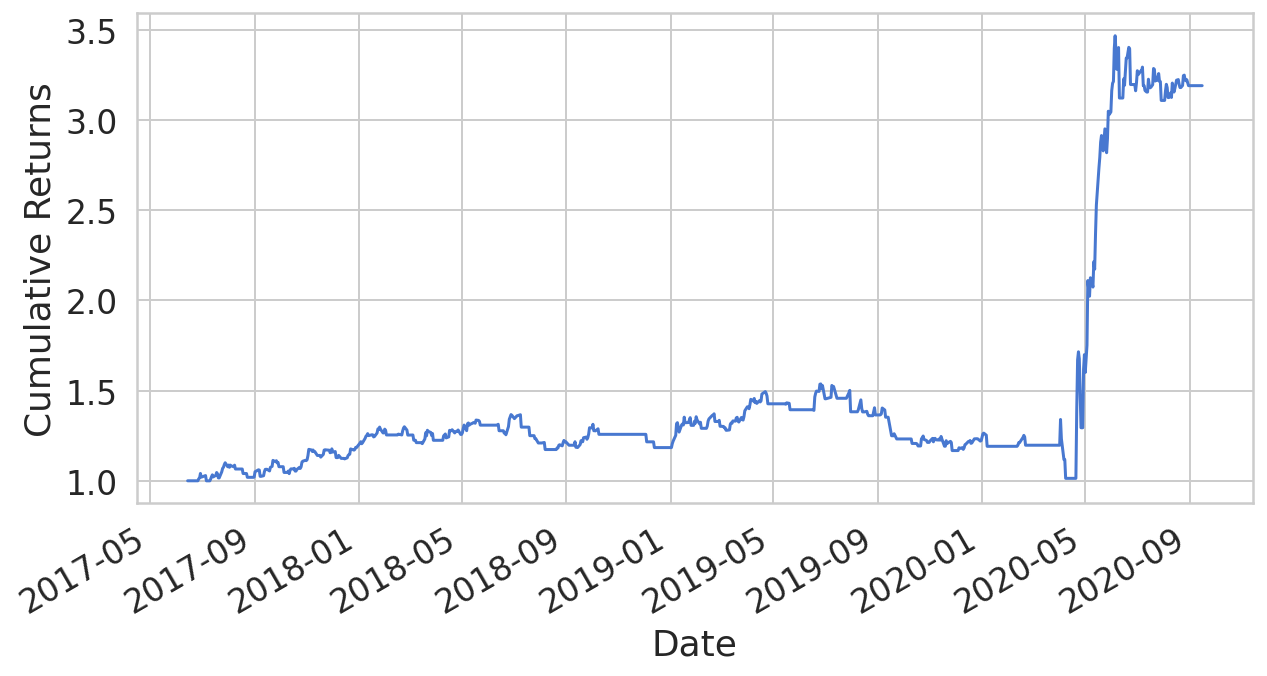

In [ ]:
oil = DataFrame()

oil['price'] = df[-len(y_test):]['Close']
oil['pred_next_day'] = y_pred
oil['actual_price_next_day'] = y_test
oil['returns'] = oil['price'].pct_change().shift(-1)
oil['signal'] = np.where(oil.pred_next_day.shift(1) < oil.pred_next_day,1,0)
oil['strategy_returns'] = oil.signal * oil['returns']
((oil['strategy_returns']+1).cumprod()).plot(figsize=(10,5))
plt.ylabel('Cumulative Returns')
plt.show()

In [ ]:
'Sharpe Ratio %.2f' % (oil['strategy_returns'].mean()/oil['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 1.04'

In [ ]:
df.loc[:,'pred_price'] = model.predict(df[['ema10', 'ema20']])
df.loc[:,'signal'] = np.where(df.pred_price.shift(1) < df.pred_price,"Buy","Sell")
df.loc[:,'price_direction'] = df['signal'].replace(('Sell', 'Buy'), (0, 1))
df.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,ema10,ema20,price_tomorrow,pred_price,signal,price_direction
Date,,,,,,,
2020-09-10,37.299999,39.858000,40.875120,37.330002,39.863501,Sell,0
2020-09-11,37.330002,39.398364,40.537490,37.259998,39.395001,Sell,0
2020-09-14,37.259998,39.009571,40.225348,38.279999,39.000952,Sell,0
2020-09-15,38.279999,38.876921,40.040076,40.160000,38.873165,Sell,0
2020-09-16,40.160000,39.110208,40.051498,40.970001,39.124464,Buy,1


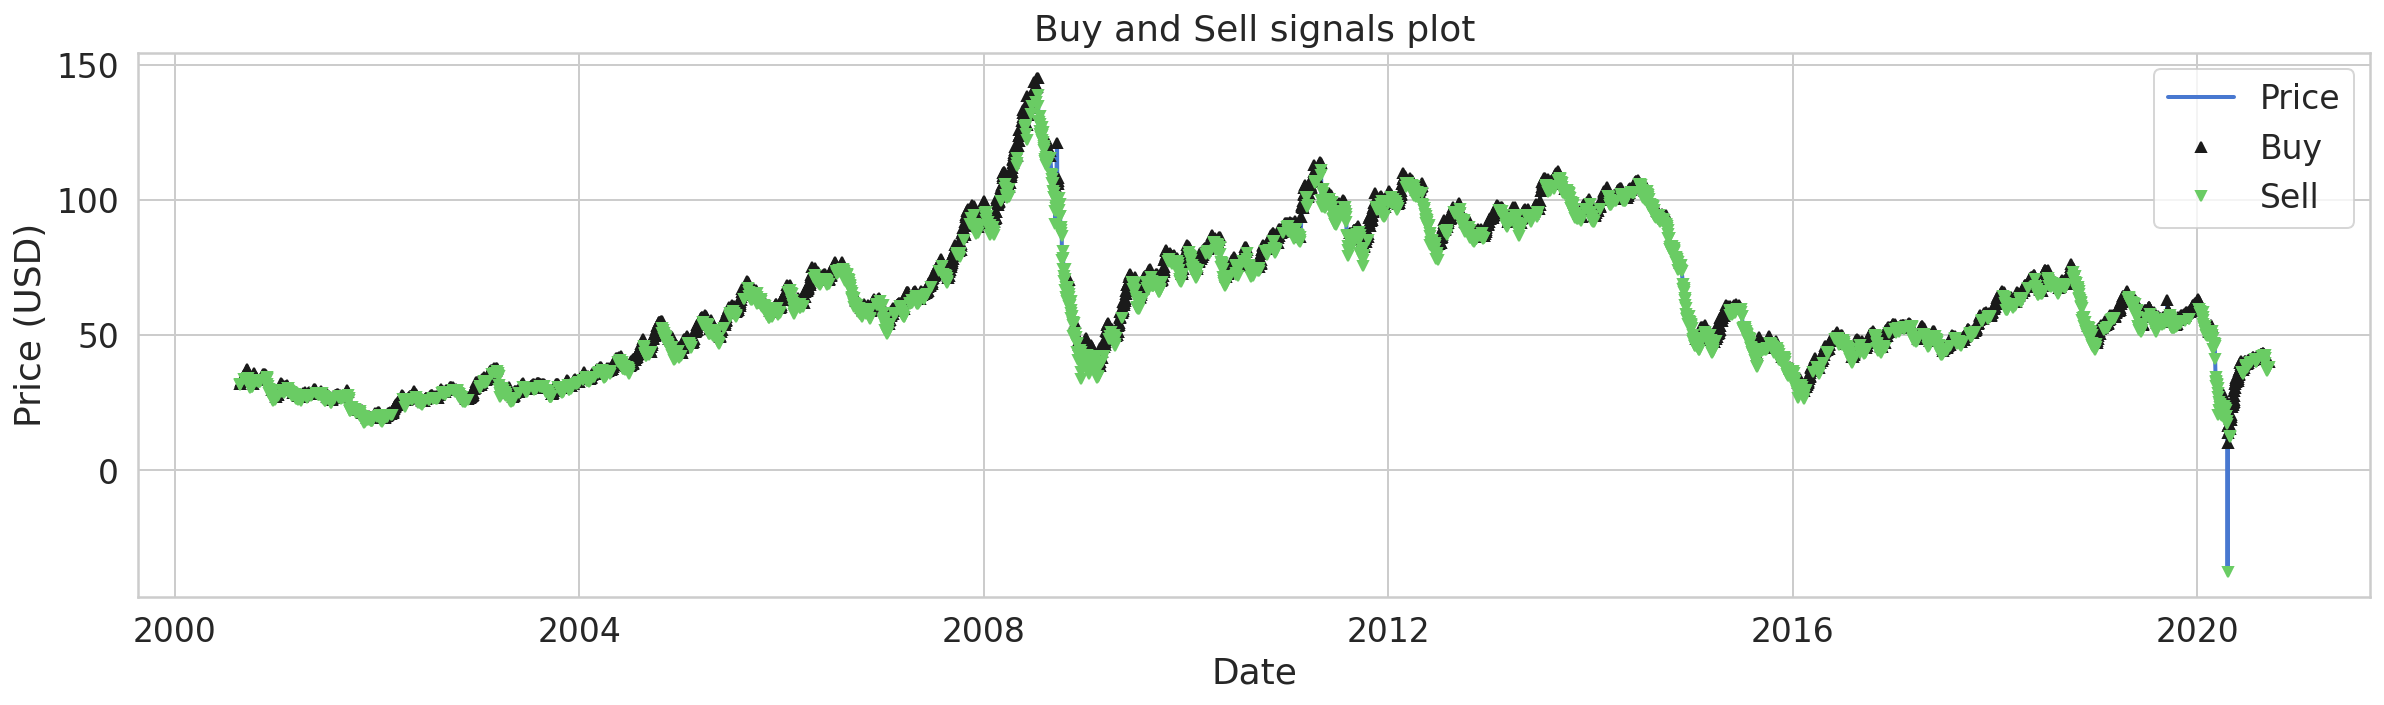

In [72]:
buys = df.loc[df['price_direction'] == 1]
sells = df.loc[df['price_direction'] == 0]

# Plot 
fig = plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Close'], lw=2., label='Price')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Close'], 
         '^', markersize=5, color='k', lw=2., label='Buy')
plt.plot(sells.index, df.loc[sells.index]['Close'], 
         'v', markersize=5, color='g', lw=2., label='Sell')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title('Buy and Sell signals plot')
plt.legend(loc='best')

# Display everything
plt.show()

In [ ]:
print('Data shape:', df.shape); print();
X = np.array(df[['ema10', 'ema20']])

# Define dependent variable
y = np.array(df['price_direction'])

Data shape: (5033, 7)



In [ ]:
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size = 0.80, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

Length train set: 4195
Length test set: 838


In [ ]:
# Use Cross-validation/backtesting.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std


print('\033[4mLogistic Regression\033[0m')
model_clf = LogisticRegression(solver='liblinear', C=0.05, random_state=0).fit (X_train,y_train)

model_scores = cross_val_score(model_clf, X_train, y_train, cv=5);
model_mean = model_scores.mean();
print ('Accuracy score (%):', model_mean*100); 

Logistic Regression
Accuracy score (%): 71.96662693682956


In [ ]:
y_pred = model_clf.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.66%


In [ ]:
# Run the code to view the classification report metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred)); print();
print ('Classification report:')
print (classification_report(y_test, y_pred))

Confusion matrix:
[[229 120]
 [ 84 405]]

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       349
           1       0.77      0.83      0.80       489

    accuracy                           0.76       838
   macro avg       0.75      0.74      0.75       838
weighted avg       0.75      0.76      0.75       838



In [ ]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(y_test,y_pred)))

Precision score: 0.7714285714285715


In [ ]:
print('\033[4mProbability of prediction results\033[0m')
predict_prob = model.predict_proba(X_test)
predict_prob = DataFrame(predict_prob)
print(predict_prob.tail(10))